# Aside 
### Coding Tip 1

Don't be a premature optimisatiser. ([Unknown](https://effectiviology.com/premature-optimization/#:~:text=Summary%20and%20conclusions-,Premature%20optimization%20is%20the%20act%20of%20trying%20to%20make%20things,tasks%20for%20you%20to%20handle.))

    Premature optimization is the act of trying to make things more efficient at a stage when it is too early to do so, such as by working on trivial aspects of a business that you're developing, despite the fact that there are more important tasks for you to handle.
    
As it matters to us, if you recall last week where there was that enormous chunk of code that was incredibly difficult to understand. Don't worry about understanding all the tiny little things that is happening in every line of code. Try to see if you can understand the general idea of the code, and see if you can implement this.

As last week, we didn't try to understand the code. But we tried to understand the big ideas in the code. 

    Here are the key details: 
        1. Yeo-Johnson transformation for the credit amount and age. The code allows you to verify that these transformations help. 
        2. Dummy encoding for the categorical variables, noting that they all have low cardinality. 
        3. We treat the discrete variables in the same way as categorical variables (since they only have a few possible values).
        4. We standardise the predictors (not strictly necessary, but it makes the optimisation algorithm more stable). 

But let us look at the code and see if we can figure this out ourselves.

In [1]:
from sklearn.preprocessing import PowerTransformer, StandardScaler

def feat_engineering(df, variables, dummy=True, transformation=True):
    
    data = df.copy()
    
    # What are we doing here?
    continuous = variables[variables == 'continuous'].index.tolist()
    discrete = variables[variables == 'discrete'].index.tolist()
    categorical = variables[variables == 'categorical'].index.tolist()
    binary = variables[variables == 'binary'].index.tolist()
    response = variables[variables == 'response'].index.tolist()
    
    # Clearly we are simply getting dummy variables. But, importantly, we can't get dummy variables
    # for all the variables, as some may be continious. Hence we only get the dummy variables for 
    # some of the variables
    labels = discrete + categorical 
    for label in labels:
        if dummy:
            dummies = pd.get_dummies(data[label], prefix=label, drop_first=True)
        else:
            dummies = pd.get_dummies(data[label], prefix=label)
        data = data.join(dummies)
        binary += list(dummies.columns)
    
    # Clearly we are doing the Yeo-Johnson transformation. But, again, we can't do the transformation on all
    # of the dataset
    transf = ['amount', 'age']
    if transformation: 
        yj_transf = PowerTransformer(method='yeo-johnson').fit(data.loc[index_train, transf])
        data[transf] = yj_transf.transform(data[transf])
    
    # Clearly we are just rescaling
    predictors = continuous + binary
    scaler = StandardScaler().fit(data.loc[index_train, predictors])
    data[predictors] = scaler.transform(data[predictors])
    
    X_train = data.loc[index_train, predictors]
    X_test = data.loc[index_test, predictors]

    y_train = data.loc[index_train, response].to_numpy()
    y_test = data.loc[index_test, response].to_numpy()
    
    return X_train, np.ravel(y_train), X_test, np.ravel(y_test), predictors

So, when you go to code, you don't have to worry about making the code as clean and optimised as possible. All you need to know how to do is to just know how to do a Yoe-Johnson transform, get dummy variabes, perform scalar transformation, etc. You don't need it to be as optimised as possible, all you need is for it to work.

Of course, though, when you submit the final code it is ideal for it to be optimised and clean so the markers can understand what you did easily. But, since for now you are just hacking code up (meaning typing code and seeing what works and doesn' work), it's fine for it to be messy.


### Coding Tip 2
There are two ways to not know something.
1. Not know what you don't know
2. Known what you don't know

Imagine you before you took this course, and now that you've taken this course.

Before you took this course you probably don't know what cross-validation, Yoe-Johnson transformation, feature engineering, etc. But after this course is finished you are now aware things like this existed. 

Know while you may not remeber the exact specifics of how Yoe-Johnson transformation works, it doesn't matter. It matters more that you know it exists, and when you need it you can just search it.

In the same sense, this is how you program. You don't have to know all the exact and little details about the code. All you need to know is that something like Yoe-Johnson (or scalar) transformation exists. When you need to implement it you can just search on google, or look through our notebooks.

<img align="center" src="http://sydney.edu.au/images/content/about/logo-mono.jpg">
<h1 align="center" style="margin-top:10px">Statistical Learning and Data Mining</h1>
<h2 align="center" style="margin-top:20px">Tutorial 9: Regularised Linear Models</h2>
<br>

This tutorial will show how to implement regularisation methods for linear regression in Python.

<a href="#1.Ames-Housing-Data">Ames housing data</a> <br>
<a href="#2.Exploratory-Data-Analysis">Exploratory data analysis</a> <br>
<a href="#3.Feature-Engineering">Feature engineering</a> <br>
<a href="#4.Ridge-Regression">Ridge regression</a> <br>
<a href="#5.Lasso">Lasso</a> <br>
<a href="#6.Elastic-Net">Elastic net</a> <br>
<a href="#7.Validation-results">Validation results</a> <br> 
<a href="#8.Thing-to-try">Things to try</a> <br> 

In [52]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') 

In [53]:
# Plot settings
sns.set_context('notebook') # optimises figures for notebook display
sns.set_style('ticks') # set default plot style
colours = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', 
          '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours) # set custom color scheme
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error

## 1. Ames Housing Data

In this tutorial we will continue working with the Ames Housing dataset ([De Cock 2011](http://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627)) from the feature engineering tutorial. 

Our objective is to predict the sale price of the houses (the last column in the dataset). We assume that the loss function is the squared error loss on the log scale. We work with version of the dataset in which we already took care of time-consuming feature engineering for all the variables

In [55]:
data=pd.read_csv('Data/ames-processed-regression.csv')
data.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GarageArea,...,SaleCondition_Partial,PoolNA,MiscFeatureNA,AlleyNA,FenceNA,FireplaceNA,GarageNA,BasementNA,MasVnrNA,SalePrice
0,4.948760,10.366278,112.0,639.0,0.0,441.0,7.412160,0,0,528.0,...,0,1,1,1,1,0,0,0,0,215000
1,4.382027,9.360655,0.0,468.0,144.0,270.0,6.797940,0,0,730.0,...,0,1,1,1,0,1,0,0,0,105000
2,4.394449,9.565704,108.0,923.0,0.0,406.0,7.192182,0,0,312.0,...,0,1,0,1,1,1,0,0,0,172000
3,4.532599,9.320091,0.0,1065.0,0.0,1045.0,7.654443,0,0,522.0,...,0,1,1,1,1,0,0,0,0,244000
4,4.304065,9.534595,0.0,791.0,0.0,137.0,6.833032,701,0,482.0,...,0,1,1,1,0,0,0,0,0,189900


The auxiliary file helps us to keep track of the variables. I recommend that you always do something like this, because it helps you to work with all variables of the same type in one batch. We will use this information below. 

In [56]:
variables=pd.read_csv('Data/ames-processed-regression-variables.csv', index_col='variable')
variables.head()

,type
variable,
LotFrontage,continuous
LotArea,continuous
MasVnrArea,continuous
BsmtFinSF1,continuous
BsmtFinSF2,continuous


In [57]:
variables.value_counts()

type      
dummy         209
continuous     20
discrete        7
response        1
dtype: int64

Like in the previous tutorial, we split the data into a training set and validation set. The response is the log of the sale price. 

In [58]:
response='SalePrice'
predictors=list(data.columns.values[:-1])

# Randomly split indexes
index_train, index_val  = train_test_split(np.array(data.index), train_size=0.7, random_state=12)

# Write training and test sets
train = data.loc[index_train,:].copy()
validation =  data.loc[index_val,:].copy()

# Something to try later
# corr = data.corr()[response].abs().sort_values()
# drop = corr[corr<0.05].index
# predictors = [x for x in predictors if x not in drop]

y_train = np.log(train[response].to_numpy())
y_val = np.log(validation[response].to_numpy())

In [9]:
len(predictors)

236

## 2. Exploratory Data Analysis

Let's do an abbreviated EDA to get a sense of the prepared dataset. Now it's when we get to use the table of predictors.

In [59]:
continuous = list(variables[variables['type']=='continuous'].index)
print(continuous)

['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'Age', 'RemodAge', 'GarageAge']


We show regression plots for all continuous predictors.

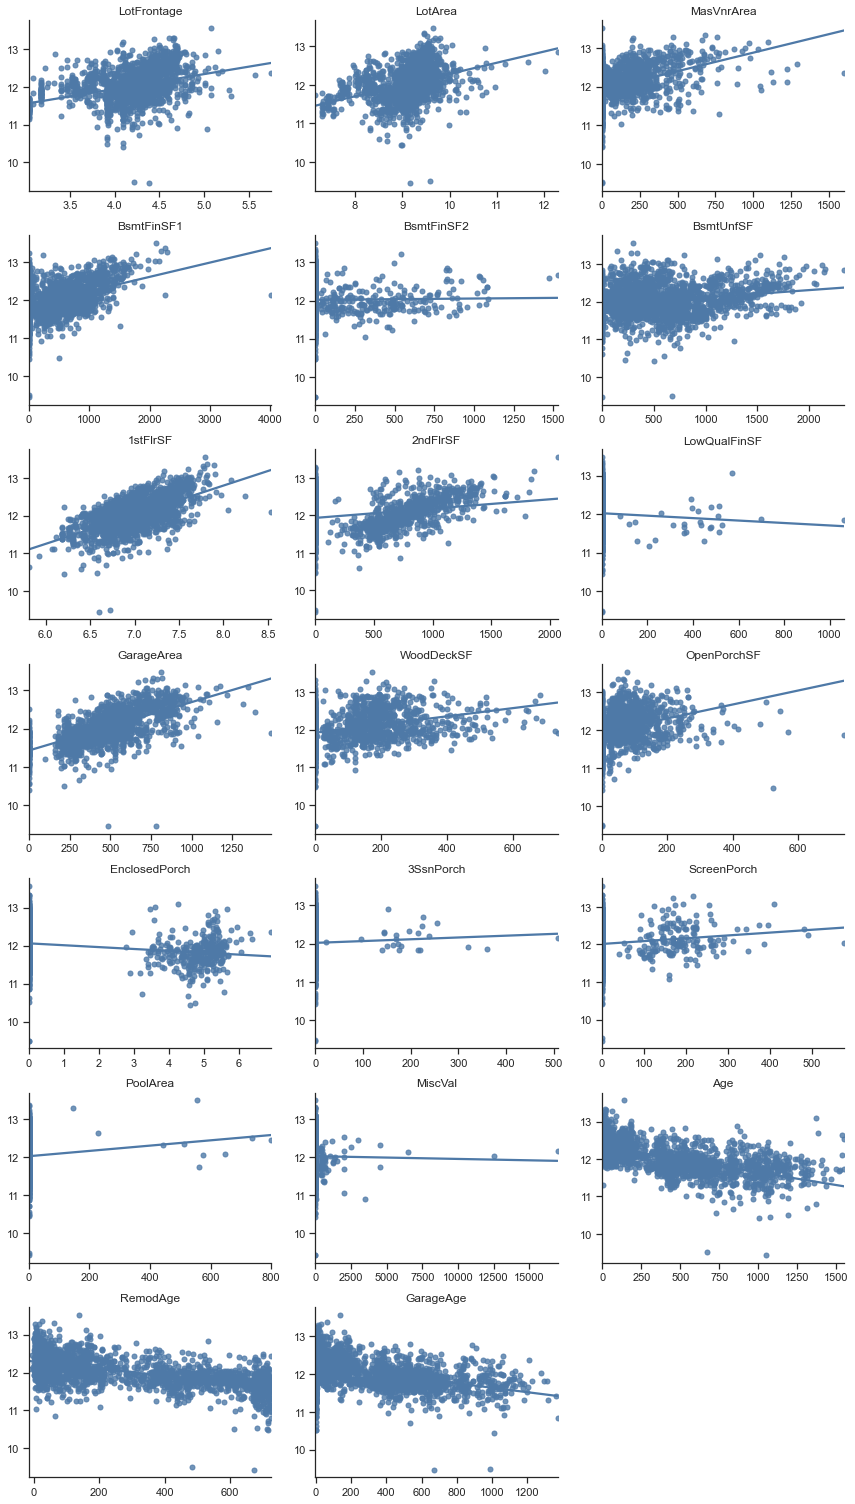

In [11]:
from statlearning import plot_regressions

plot_regressions(train[continuous], y_train)
plt.show()

We can do the same for the discrete variables. 

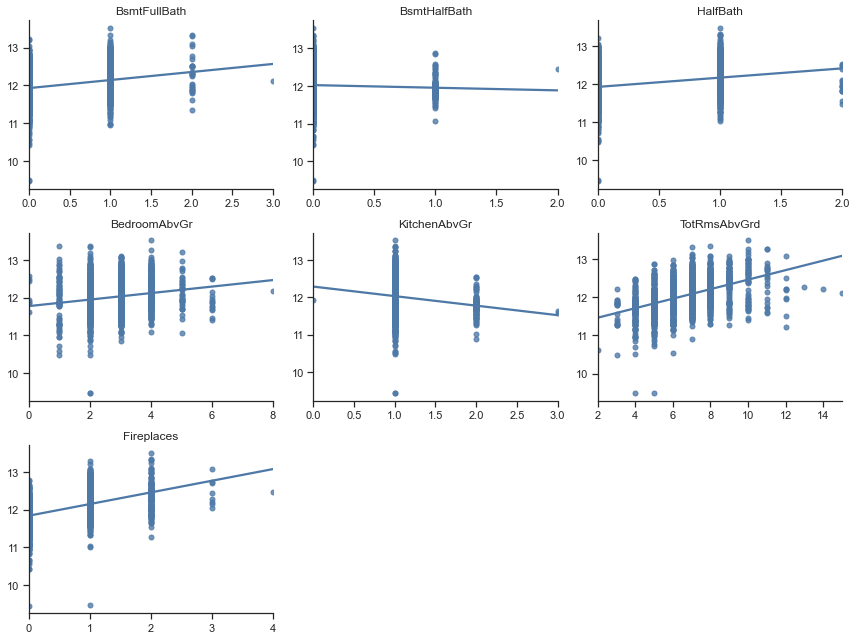

In [12]:
discrete = list(variables[variables['type']=='discrete'].index)
plot_regressions(train[discrete], y_train)
plt.show()

## 3. Feature Engineering

Even though we have already done most of the feature engineering in the background, it is essential to scale the predictors  before fitting regularised linear models.

In the lectures we discussed both standardisation and min-max scaling. Standardisation is our default choice, but min-max turns out to work better for this dataset based on model selection.  The Scikit-Learn [<TT>MinMaxScaler</TT>](https://scikit-learn.org/0.21/modules/generated/sklearn.preprocessing.MinMaxScaler.html) method makes it easy for us to process the predictors in this way.

In [46]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Alternative to try later
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()

X_train = scaler.fit_transform(train[predictors])
X_val = scaler.transform(validation[predictors])

A difficulty that we often have is that numerical features and dummy variables are not directly comparable, no matter the scaling. The ideal would be to (at least try to) use different penalties for the two types of features, but this is not a standard implementation. 

## 4. Ridge Regression

$$\large \sum^N_{i=1}\left(y_i - \sum_{j=0}^M\beta_jx_{i,j}\right)^2 + \alpha\sum_{j=0}^M\beta_j^2$$

The [RidgeCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html) class is the most convenient implementation for ridge regression. The package automatically runs a grid search to select the penalty lambda. 

The reason for using `RidgeCV`, as opposed to running a grid search on the [<TT>Ridge</TT>](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) class, is that there is an efficient algorithm for computing the path of solutions as we vary the Ridge penalty. The same is the case for the lasso implementation below.

We need to manually specify a grid of the penalty weight values (called alphas by the package). We often do this by generating a grid of values on a logarithmic scale. The package uses efficient leave-one-out cross-validation (generalised cross-validation) by default for ridge regression.

In [14]:
from sklearn.linear_model import RidgeCV

alphas = list(np.logspace(-15, 15, 151, base=2))
ridge = RidgeCV(alphas=alphas)
ridge.fit(X_train, y_train)

RidgeCV(alphas=array([3.05175781e-05, 3.50554918e-05, 4.02681858e-05, 4.62559987e-05,
       5.31341897e-05, 6.10351562e-05, 7.01109836e-05, 8.05363715e-05,
       9.25119975e-05, 1.06268379e-04, 1.22070312e-04, 1.40221967e-04,
       1.61072743e-04, 1.85023995e-04, 2.12536759e-04, 2.44140625e-04,
       2.80443934e-04, 3.22145486e-04, 3.70047990e-04, 4.25073517e-04,
       4.88281250e-04, 5.60887869e-0...
       2.70235220e+03, 3.10418753e+03, 3.56577511e+03, 4.09600000e+03,
       4.70506846e+03, 5.40470440e+03, 6.20837506e+03, 7.13155021e+03,
       8.19200000e+03, 9.41013692e+03, 1.08094088e+04, 1.24167501e+04,
       1.42631004e+04, 1.63840000e+04, 1.88202738e+04, 2.16188176e+04,
       2.48335002e+04, 2.85262009e+04, 3.27680000e+04]),
        cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
        scoring=None, store_cv_values=False)

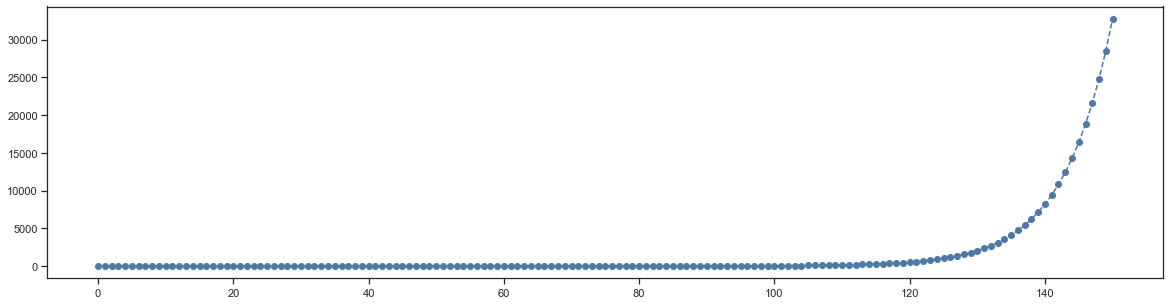

In [15]:
fig = plt.figure(figsize = (20, 5))
plt.plot(alphas, 'o--')

The statlearning module has a function that allows us to faciltate visualisation of the estimated coefficients.

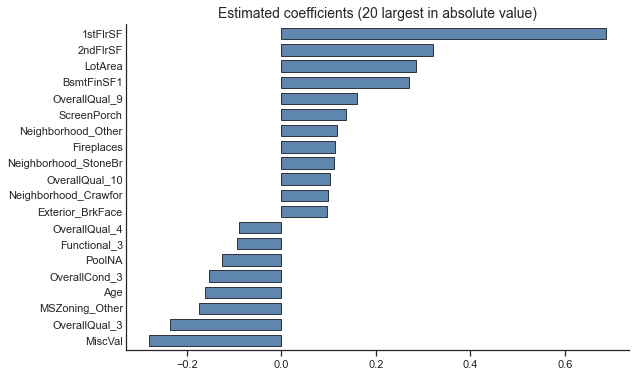

In [16]:
from statlearning import plot_coefficients
plot_coefficients(ridge, predictors)
plt.show()

In [17]:
np.sum(abs(ridge.coef_) == 0.0)

0

## 5. Lasso
$$\large \sum^N_{i=1}\left(y_i - \sum_{j=0}^M\beta_jx_{i,j}\right)^2 + \alpha\sum_{j=0}^M|\beta_j|$$

Similarly to the above, we use the [<TT>LassoCV</TT>](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html) class to fit the lasso model using the in-built algorithm for hyperparameter optimisation.  

### Aside
Unlike ridge regression where we have to try different values of $\alpha$ (or regularisation strength), with lasso there is an algorithm that lets us find the best value of $\alpha$. We don't have to try different values, the algorithm will find it itself.

In [47]:
from sklearn.linear_model import LassoCV

lasso = LassoCV(cv=5)
lasso.fit(X_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

The lasso shrinks 85 out the 236 coefficients to zero.

In [48]:
np.sum(lasso.coef_==0.0)

85

In [49]:
np.sum(lasso.coef_==0.0)/len(lasso.coef_)

0.3601694915254237

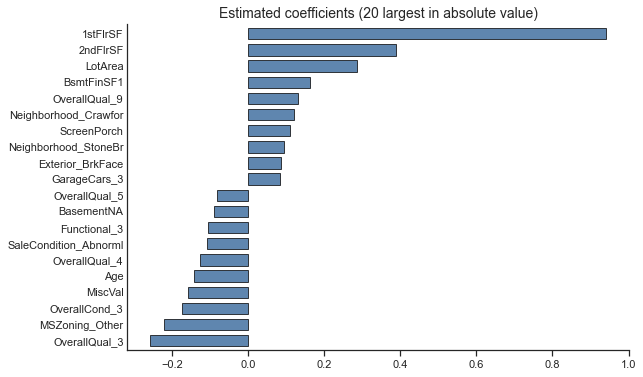

In [21]:
plot_coefficients(lasso, predictors)
plt.show()

## 6. Elastic Net
$$\large \sum^N_{i=1}\left(y_i - \sum_{j=0}^M\beta_jx_{i,j}\right)^2 + \alpha\left(\lambda \sum_{j=0}^M|\beta_j| + \frac{1}{2}(1-\lambda)\sum_{j=0}^M\beta_j^2\right)$$

Finally, we also consider the elastic net method.

### Aside
Note that like ridge regression, with elastic net regression we have to now specify what values of $\alpha$ and $\lambda$ to search through. If you don't say which value of $\alpha$ to choose from, then the algorithm will automatically choose 100 different values of $\alpha$.

In [50]:
from sklearn.linear_model import ElasticNetCV

enet = ElasticNetCV(l1_ratio=[0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 0.99], cv=5)
enet.fit(X_train, y_train)

ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
             l1_ratio=[0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99],
             max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
             positive=False, precompute='auto', random_state=None,
             selection='cyclic', tol=0.0001, verbose=0)

The hyperparameter optimisation essentially puts all the weight on the lasso penalty.

In [51]:
enet.l1_ratio_

0.99

In [24]:
np.sum(enet.coef_==0.0)

82

In [25]:
np.sum(enet.coef_==0.0)/len(enet.coef_)

0.3474576271186441

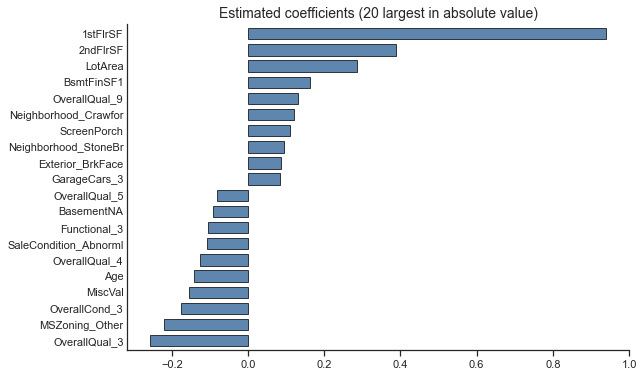

In [26]:
plot_coefficients(enet, predictors)
plt.show()

## 7. Validation results


In [27]:
ols = LinearRegression()
ols.fit(X_train, y_train)

columns=['RMSE', 'R2', 'MAE']
rows=['OLS', 'Lasso', 'Ridge', 'Elastic Net']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[ols, lasso, ridge, enet]

for i, method in enumerate(methods):
    
    y_pred  = method.predict(X_val)   
    results.iloc[i,0] = np.sqrt(mean_squared_error(y_val, y_pred))
    results.iloc[i,1] = r2_score(y_val, y_pred)
    results.iloc[i,2] = mean_absolute_error(y_val, y_pred)

results.round(3)

,RMSE,R2,MAE
OLS,0.124,0.905,0.076
Lasso,0.116,0.917,0.075
Ridge,0.120,0.911,0.076
Elastic Net,0.116,0.917,0.075


## 8. Things to try

The code above left some things for you to try. You can uncomment the relevant parts and run the notebook again to check how the modification affects the validation set results. One change at a time!  

* Standardisation rather than min-max scaling.  This will show you how a detail of feature engineering can make a significant difference for performance, as much or even more so than using different learning algorithms. 

* Feature screening. It either hurts or does not help the regularised methods at all, since they are designed to handle the situation in which we have many features. Feature screening can still be useful in some cases, but you should be careful not to discard features prematurely. Learning algorithms can extract useful information from combinations of features in non-obvious ways.

# Cross-Entropy Loss Function
$$\large - \frac{1}{N}\sum_{i=1}^Ny_i\cdot\log(f(x_i)) + (1-y_i)\cdot\log(1-f(x_i))$$

How can we have 100% accuracy while still have high loss?

Suppose we had a training set, $(X_1, 1)$ and $(X_2, 0)$. Now suppose we built a model (like logistic regression or something else) where it wasn't very confident with its prediction:
$$f(X_1) = 0.51\quad\textrm{ and }\quad f(X_2)=0.49$$

Then the cross-entropy loss is
$$-\frac{1}{2}\bigg(\Big[1\cdot\log(f(x_1)) + (1-1)\cdot\log(1-f(x_1))\Big]+\Big[0\cdot\log(f(x_2)) + (1-0)\cdot\log(1-f(x_2))\Big]\bigg)$$
$$=-\frac{1}{2}\bigg(\log(f(x_1))+\log(1-f(x_2))\bigg)=-\frac{1}{2}\bigg(\log(0.51)+\log(1-0.49)\bigg)=0.673$$

In contrast, if our model was very confident
$$f(X_1) = 0.99\quad\textrm{ and }\quad f(X_2)=0.01$$
$$-\frac{1}{2}\bigg(\log(0.99)+\log(1-0.01)\bigg)=0.01$$

As such, this loss function not only penalises you for being wrong, but it also penalise you for being not-confident.

In [28]:
import numpy as np

In [29]:
-0.5*(np.log(0.51) + np.log(1-0.49))

0.6733445532637656

In [30]:
-0.5*(np.log(0.99) + np.log(1-0.01))

0.01005033585350145

# Aside
Don't look at this code. Eventhough I wrote it, I don't really understand it

In [31]:
import scipy
fact = lambda x: scipy.special.gamma(x + 1)

In [32]:
def possion_pmf(l):
    y = np.arange(0, 35)
    p = np.exp(-l)*(np.power(l,y))/np.array([fact(yi) for yi in y])
    return y, p

In [33]:
%matplotlib inline

$$\large Y_i \sim \textrm{Possion}(X_i)$$

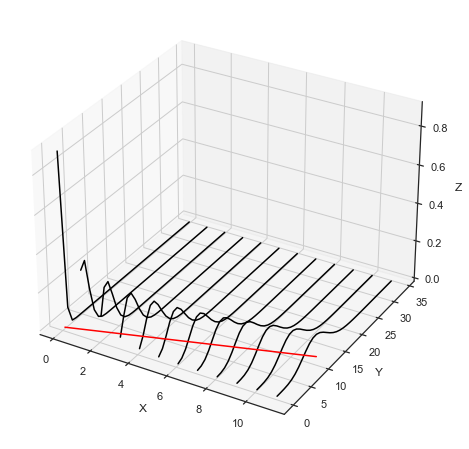

In [34]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

mu = np.arange(0.1, 12, 1)
for k in mu:
    y, z = possion_pmf(k)
    ax.plot3D(k*np.ones(len(z)), y, z, 'black')

ax.plot3D(mu, mu, 'red')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

$$\large Y_i \sim \textrm{Possion}(3X_i)$$

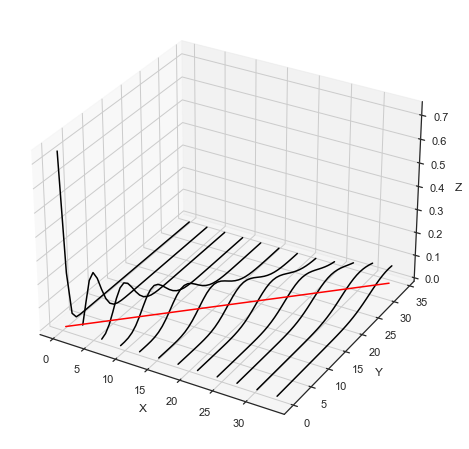

In [35]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

mu = np.arange(0.1, 12, 1)*3
for k in mu:
    y, z = possion_pmf(k)
    ax.plot3D(k*np.ones(len(z)), y, z, 'black')

ax.plot3D(mu, mu, 'red')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

$$\large Y_i \sim \textrm{Possion}(5)$$

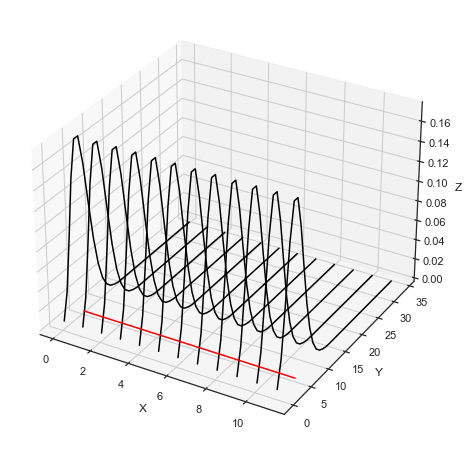

In [36]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

mu = np.arange(0.1, 12, 1)
l = 5
for k in mu:
    y, z = possion_pmf(l)
    ax.plot3D(k*np.ones(len(z)), y, z, 'black')

ax.plot3D(mu, l*np.ones(len(mu)), 'red')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

### Formatting

The two cells below format the notebook for display online. Please omit them from your work.

In [37]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Source+Sans+Pro|Open+Sans:800&display=swap');
</style>

In [38]:
from IPython.core.display import HTML
style = open('css\jupyter.css', "r").read()
HTML('<style>'+ style +'</style>')

FileNotFoundError: [Errno 2] No such file or directory: 'css\\jupyter.css'